# DTEK0042 Exercise 4
    Group Members:
    1. Emilia Kalliokoski
    2. Amanda Myntti
    3. Lauri Orava

*** Note for Google Colab Users ***
     Because Google Colab doesn't have a button to convert your notebook to .html format here is a quick work around:
   1. open a new google colab notebook
   2. in the files section in google colab, upload the .ipynb file you want to be converted to .html
   3. in your new open notebook run this command in an empty cell: !jupyter nbconvert --to html YourFileName.ipynb
   4. after the command is finished running refresh the page
   5. In your files section you should see your original .ipynb file that you uploaded and then a .html file of that same notebook.
   6. download the .html file and you're good to go!

In this exercise, you are required to analyze a SCG signal step-by-step as outlined below.  The deliverables for this exercise are a jupyter notebook and a .html file exported form the notebook. The notebook should includes your code, observations, graphs, and conclusions made upon analyzing the given SCG signals. Please provide caption and description for every figure. 

## 1- library Imports

In [13]:
#scipy imports
import scipy 
from scipy import stats
from scipy.signal import butter, filtfilt, freqz, welch

#numpy imports
import numpy as np

#matplotlib imports
import matplotlib.pyplot as plt

#sklean imports
from sklearn.decomposition import PCA
from sklearn import preprocessing as prep
#other imports
import glob
import pandas

# Data Import 
* Load the .txt files of SCG data that are stored in the folder named “dataset” into your python environment.  
* For each .txt data file, select the 3rd column which contains the Z-axis of the SCG signals. 
* Note: the sampling frequency of this signal is 200 Hz. 

        Hint:  
        * to automate the loading process you can get a list of all data file paths using glob package and subsequently load the files in a for loop. 
        
        * dataFiles = glob.glob(path_to_dataset) to get a list of file paths of "dataset\xxdata.txt"
        
         then load the paths one by one in a loop

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# check path
! ls drive/MyDrive/Notebooks/Data/dataset/

Noisy_data_1.txt  Noisy_data_3.txt  Normal_data_1.txt  Normal_data_3.txt
Noisy_data_2.txt  Noisy_data_4.txt  Normal_data_2.txt  Normal_data_4.txt


In [4]:
PATH = "drive/MyDrive/Notebooks/Data/dataset/"

dataFiles = glob.glob(PATH+"*.txt")

In [5]:
data = {}
for i, path in enumerate(dataFiles):
  label = path.split("/")[-1]
  data[label] = np.loadtxt(path, delimiter=" ")[:,2]

fs = 200.0

# Noisy Vs Normal Plotting

* Plot the z-axis SCG signal from the file "Noisy_data_1.txt" and plot the z-axis SCG signal from the file "Normal_data_1.txt" 
* Describe your observations and how the plots differ from one another.


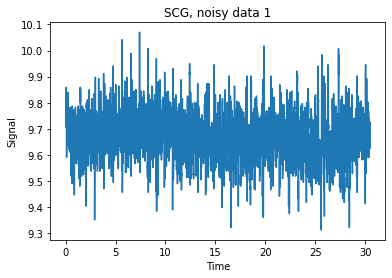

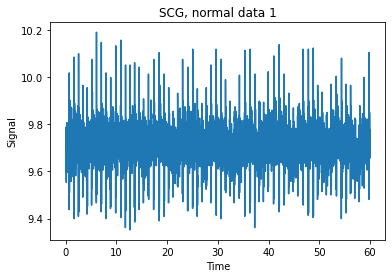

In [6]:
# make time interval array
x_noisy = np.arange(0,len(data['Noisy_data_1.txt'])*1/fs, 1/fs)
x_normal = np.arange(0,len(data['Normal_data_1.txt'])*1/fs, 1/fs)

plt.plot(x_noisy, data['Noisy_data_1.txt'])
plt.title("SCG, noisy data 1")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.show()
plt.close()
plt.plot(x_normal, data['Normal_data_1.txt'])
plt.title("SCG, normal data 1")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.show()


There are a few key differences:
- Heart cycle can be easily detected form the normal data, unlike form the noisy data which has a lot of high level noise.
- The noisy data is less centered around one value, and moves around a bit.
- The noisy data is smaller than the normal data, noisy data was measured for 30s and normal for 60s

Despite these, if we plot all of the data, it is easy to think that the signals still look really similar. However, if we plot only a small section of the signal (first 2000 data points, or 10s), we see that the noise affects the signal greatly:

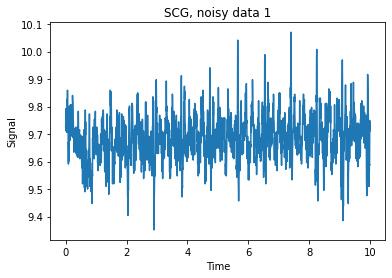

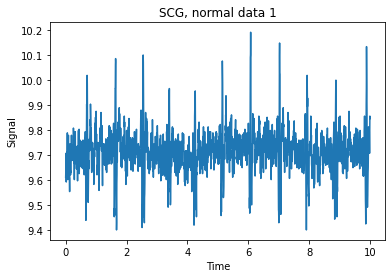

Because of this, we actually initially thought that the measurement frequency was different between the noisy and normal data, especially, since noisy data is exactly half the length of normal data. But finally, we thought that if this were the case, it would have been either stated in the exercise brief or would be more obvious from the plots. We can also count 12 peaks in 10s in both graphs, which is a reasonable period for a SCG graph and confirms that the measurement frequency is same in both.

# Data Segmentation 
* Here is a simple function to use for data segmentation
* Segment the Z-axis signals into 5-second segments
* The sampling frequency used to record these signals is 200 Hz.
* Store the segments and the accompanying labels

In [7]:
#code (provided)

def _slicing(sig, file_label, segment_length = 1000):
    
    """
    inputs:
    sig : input array to be segmented
    file_label : label to be applied to segmented signal
    segment_length : Length in samples of the segments produced from the input signal
    
    outputs:
    sig_sliced : a list of segments
    label : a list of corresponding labels for the segmented signal 
    
    """

    sig_sliced = []
    label = []
    
    # slicing 
    
    for i in np.arange(int(len(sig)/segment_length)):

        sig_sliced.append( sig[i*segment_length:(i+1)*segment_length] )

        label.append(file_label)
        
    return (sig_sliced , label)


# Feature Extraction Function Creation
*  Define a function and name it “feature_extraction” in which you compute and return the features listed below
    * *Time Domain Features*:  mean, standard deviation, interquartile-range, median, peak-to-peak range, skewness, kurtosis, and root mean square. 
    * *Frequency Domain Features*: power spectral density (using welch function of scipy)
    
        * For power spectral density, Calculate the total power spectral density within frequency bins of 4 Hz steps. Discard the frequencies above 40 Hz. Get the power within each bin.
    
        Hint:
        
        Reference: https://docs.scipy.org/doc/scipy/reference/stats.html for skewness, kurtosis, interquartile-range(iqr)
        
        Reference: https://numpy.org/doc/stable/reference/routines.statistics.html for other time domain features
        
        Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html for transforming to zero mean and unit variance



In [14]:
#code
def feature_extraction(sig, fs = 200):
    
    
    """
    inputs:
    sig : input array to extract features from
    fs : sampling frequency of input array

    
    outputs:
    feature_array: an array containing all the features extracted from the signal 
    """
    

    feature_array = []
    
    ########################################## statistical features - time domain

    # mean
    feature_array.append(np.mean(sig))
    # standard deviation 
    feature_array.append(np.std(sig))
    # interquartile-range
    a,b = np.percentile(sig, [75 ,25])
    iqr = b-a
    feature_array.append(iqr)
    # median 
    feature_array.append(np.median(sig))
    # peak-to-peak range
    feature_array.append(np.ptp(sig))
    # skewness
    feature_array.append(stats.skew(sig))
    # kurtosis
    feature_array.append(stats.kurtosis(sig))
    # root mean square
    rms = np.sqrt(np.mean(sig**2))
    feature_array.append(rms)


    

        
    ########################################## PSD 
    
    # transforming to zero mean and unit variance -- only do this when extracting PSD
    # Hint: transformed_sig = function_for_scale(sig)


    # zero mean and unit variance
    transformed_sig = prep.scale(sig)
    
    # provided code
    frequencies , PSD = welch(transformed_sig, fs=fs)
    
    freqs_arr = np.arange(0,41,4)
    
    PSD_binned_sum = [] 
    
    for i in range(freqs_arr.shape[0]-1): 
        PSD_binned_sum.append (np.sum(PSD[np.where( (frequencies >= freqs_arr[i] ) & 
                                                   ( frequencies < freqs_arr[i+1] ) )]) )
        
    # append the results
    for bins in PSD_binned_sum:
      feature_array.append(bins)


    # return the feature array
    return feature_array


# Feature Extraction Application

* You must first segment your signals and then extract features from each segment. You could do it in the following way:



* Call the _slicing function to section all the z-axis data into 5-second segments
        Hint: Load each file in "dataFiles" with for-loop
* Use the feature extraction function you created and extract features from every segment that you have obtained.
* Store the labels and the features you extracted from each segment to numpy arrays. 
        Hint: Think of an easy way to extract the label "noisy" or "normal" from each file name
        str.split() could be used somehow in this case

In [15]:
# loop over data

features = []

for label in data:
  # get signal and whether it is noisy or normal
  signal = data[label]
  new_label = label.split('_')[0]
  
  # do the segmentation
  sliced_signal, sliced_label = _slicing(signal,new_label)

  # Extraction

  for s in sliced_signal:
    features_for_sliced = feature_extraction(s, fs=fs)
    features_for_sliced.append(new_label)
    features.append(features_for_sliced)






In [16]:
df = pandas.DataFrame(features, columns = ['mean', 'std', 'iqr', 'median','ptp','skew', 'kurt', 'rms', 'bin1', 'bin2', 'bin3','bin4','bin5','bin6','bin7','bin8','bin9', 'bin10','type'])
display(df)

,mean,std,iqr,median,ptp,skew,kurt,rms,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin10,type
0,9.711774,0.081804,-0.081405,9.713264,0.699096,0.108662,3.500005,9.712119,0.046108,0.174086,0.296335,0.400615,0.200888,0.029019,0.022603,0.017033,0.018547,0.007665,Normal
1,9.719795,0.089429,-0.086182,9.720444,0.790085,0.436180,4.023571,9.720206,0.026663,0.130828,0.267302,0.352352,0.181175,0.032839,0.016245,0.009891,0.014035,0.013316,Normal
2,9.722783,0.086084,-0.076615,9.725235,0.804443,-0.191271,4.313126,9.723164,0.033984,0.130682,0.276083,0.376038,0.158867,0.038126,0.015604,0.010151,0.021854,0.014626,Normal
3,9.717692,0.080365,-0.076615,9.720444,0.713471,-0.077251,3.462521,9.718025,0.061487,0.153402,0.262302,0.240867,0.151591,0.022805,0.014450,0.011325,0.013540,0.017030,Normal
4,9.709634,0.074192,-0.086197,9.710876,0.641647,0.141326,2.566170,9.709918,0.058446,0.165820,0.261314,0.238084,0.154138,0.027642,0.021768,0.020709,0.018185,0.019588,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,9.312654,0.126381,-0.162812,9.314026,0.881073,-0.164037,0.673236,9.313511,0.334411,0.136884,0.136195,0.088351,0.062486,0.063801,0.029198,0.033663,0.049077,0.018496,Noisy
71,9.314445,0.126107,-0.153228,9.318817,0.919373,0.041819,0.721828,9.315298,0.284592,0.342779,0.189756,0.095298,0.093676,0.061238,0.033759,0.023074,0.035241,0.025486,Noisy
72,9.318343,0.108735,-0.138855,9.318817,0.833191,-0.092976,0.774256,9.318977,0.196035,0.180758,0.155679,0.058994,0.097761,0.082748,0.029286,0.015034,0.033514,0.016020,Noisy
73,9.314416,0.106062,-0.134079,9.314026,0.895431,-0.018417,0.803480,9.315020,0.111414,0.234541,0.149646,0.097602,0.086464,0.064677,0.036592,0.025207,0.046847,0.040934,Noisy


# Standardize Features
Hint:

    Use sklearn.preprocessing.scale() to standardize the features
    Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html

In [17]:
# standardize every column

# remove labels since they can't be standardized
df_label = df.pop('type')
# standardize each column
df_scaled = df.apply(lambda x: prep.scale(x), axis=0)
# add the labels back
df = pandas.concat([df_scaled, df_label], axis = 1)
display(df)


,mean,std,iqr,median,ptp,skew,kurt,rms,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,bin10,type
0,1.735744,-0.129223,0.466283,1.742617,0.019236,0.027256,0.869372,1.734967,-0.701278,-0.513384,1.637127,3.178487,2.467119,-0.845390,-0.707417,-0.776314,-0.642598,-0.989658,Normal
1,1.772977,0.059578,0.350555,1.775878,0.275830,1.033957,1.126677,1.772508,-0.857543,-0.859557,1.182644,2.604809,2.025036,-0.688735,-1.046762,-1.183153,-0.944003,-0.510477,Normal
2,1.786847,-0.023239,0.582325,1.798072,0.316320,-0.894659,1.268978,1.786237,-0.798710,-0.860725,1.320106,2.886355,1.524765,-0.471908,-1.080972,-1.168320,-0.421706,-0.399393,Normal
3,1.763217,-0.164853,0.582325,1.775878,0.059775,-0.544192,0.850950,1.762382,-0.577683,-0.678905,1.104386,1.279639,1.361608,-1.100214,-1.142548,-1.101452,-0.977111,-0.195488,Normal
4,1.725809,-0.317681,0.350192,1.731555,-0.142773,0.127656,0.410440,1.724749,-0.602127,-0.579534,1.088907,1.246556,1.418731,-0.901862,-0.752001,-0.566893,-0.666796,0.021416,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,-0.117011,0.974532,-1.505865,-0.106822,0.532421,-0.810947,-0.519839,-0.115311,1.615643,-0.811088,-0.869680,-0.533256,-0.636611,0.581001,-0.355422,0.171011,1.396835,-0.071234,Noisy
71,-0.108698,0.967744,-1.273708,-0.084628,0.640428,-0.178203,-0.495958,-0.107016,1.215280,0.836565,-0.031236,-0.450687,0.062828,0.475908,-0.111963,-0.432193,0.472552,0.521511,Noisy
72,-0.090604,0.537615,-0.925497,-0.084628,0.397391,-0.592526,-0.470193,-0.089940,0.503595,-0.459996,-0.564669,-0.882219,0.154440,1.358015,-0.350719,-0.890167,0.357218,-0.281124,Noisy
73,-0.108830,0.471417,-0.809794,-0.106822,0.572911,-0.363352,-0.455831,-0.108308,-0.176454,-0.029595,-0.659122,-0.423291,-0.098908,0.616920,0.039215,-0.310699,1.247853,1.831477,Noisy


# Principal Component Analysis
* Principal Component Analysis (PCA) is used to reduce the dimensionality of a data set consisting of many variables correlated with each other. This can then be used to visualize the data in a more practical way. 
* Compute the first and 2nd principal components
* Plot the two components on a scatter plot with the coloring done by label
* Are these features useful to seperate the two types of signals (noisy vs normal)?
* Describe your observations.
    
        Hint:
        my_pca=PCA(n_components=2)
        pca_out = my_pca.fit_transform(input)

In [18]:
pca = PCA(n_components=2)
new_data = pca.fit_transform(df_scaled)

# new dataframe

pca_frame = pandas.DataFrame(new_data, columns = ['variable1', 'variable2'])
pca_frame = pandas.concat([pca_frame, df_label], axis=1)
display(pca_frame)

,variable1,variable2,type
0,3.161058,-4.458501,Normal
1,3.424600,-3.961535,Normal
2,3.057553,-4.096508,Normal
3,3.013769,-3.238961,Normal
4,2.384383,-3.263651,Normal
...,...,...,...
70,0.124451,1.858853,Noisy
71,0.445539,1.353013,Noisy
72,0.173623,1.031456,Noisy
73,-0.917655,0.585081,Noisy


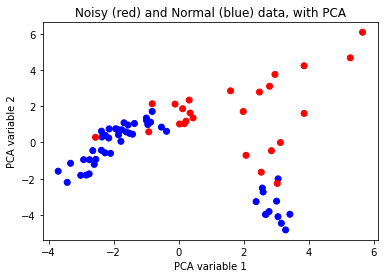

In [19]:
# plotting

colors = {'Normal':'blue', 'Noisy':'red'}

plt.scatter(pca_frame['variable1'], pca_frame['variable2'], c = pca_frame['type'].map(colors))
plt.title("Noisy (red) and Normal (blue) data, with PCA")
plt.xlabel("PCA variable 1")
plt.ylabel("PCA variable 2")
plt.show()

# Observations 

PCA provides us with some level of separation between the noisy and normal data. The acquired data is not linearly separable, but there are some similarities between the noisy examples and normal examples. The normal ones have mostly positive values (from the new PCA variables), noisy ones have either variable1 < 0 or variable2 < 0. The noisy ones form two quite tight clusters, and if we knew more about the data, this could be further examined, for example the noise in the other cluster could be from different source than in the other cluster. 

There is also one question about ```sklearn.preprocessing.scale()``` . It seems to use "population" version of the standard deviation formula, and not the sample. We had a lot of discussion about which one to use here, but ended up using the one recommended, since we're not trying to generalize to a full set of datapoints etc.